# Exploration de l'espace latent issu des données d'interconnexion

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images
from IPython.display import Image
from keras.callbacks import TensorBoard
from time import time
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
#paths in git

#root git folder 
path_main_folder = '/home/goubetcle/Documents/CVAE/marota_cvae'
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [3]:
#import class and methods from src
from keras import backend as K
from CVAE.callbacks import NEpochLogger,callbackWeightLoss
#from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE, CVAE_emb, CAE
from conso.load_shape_data import *  

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE

In [4]:
import CVAE.cvae_model
import CVAE.cvae_model_mixture
import CVAE.cvae_model_cluster
import importlib
importlib.reload(CVAE.cvae_model)
importlib.reload(CVAE.cvae_model_mixture)
importlib.reload(CVAE.cvae_model_cluster)
%load_ext autoreload
%autoreload

In [5]:
path_data = os.path.join(path_main_folder, 'data')
x_xchange = pd.read_csv(path_data+'/interconnections.csv', sep=',')[['DAT_DATE', 'FR_CWE.posNette']]
x_xchange.head()

,DAT_DATE,FR_CWE.posNette
0,2012/01/01 00:30,3108.0
1,2012/01/01 01:30,3179.0
2,2012/01/01 02:30,1312.0
3,2012/01/01 03:30,2334.0
4,2012/01/01 04:30,2140.0


In [6]:
x_xchange = x_xchange.rename(columns={'DAT_DATE':'ds', 'FR_CWE.posNette':'consumption'})
x_xchange['ds'] = x_xchange.ds.astype('datetime64')
x_xchange['consumption'] = x_xchange.consumption.astype(float)

In [7]:
dict_xconso = {'train': x_xchange.dropna()}
# Normalize input variables
dict_xconso, scaler = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption']


In [8]:
dict_xconso['train'].isna().sum()

ds             0
consumption    0
dtype: int64

In [9]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso)


In [10]:
dataset.items()

dict_items([('train', {'x': [array([[ 1.12719984,  1.1542547 ,  0.44282605, ...,  0.94619898,
         1.12948617,  0.33613081],
       [-0.06207109, -0.37224941, -0.47284778, ...,  1.14853889,
         1.30096067,  0.33460659],
       [ 1.06013426,  1.04031942,  0.9785886 , ...,  1.00602452,
         1.21712869,  0.23553243],
       ...,
       [ 1.21674763,  1.22474978,  1.37336101, ...,  1.33982822,
         0.918382  ,  0.22029026],
       [ 1.50825429,  1.6336212 ,  1.56160191, ...,  1.2479941 ,
         1.2956259 ,  0.3822384 ],
       [ 0.31707809,  1.06966062,  1.07423327, ...,  0.57848144,
         0.10178232, -0.41454645]]), array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])], 'y': array([[ 1.12719984,  1.1542547 ,  0.44282605, ...,  0.94619898,
         1.12948617,  0.33613081],
       [-0.06207109, -0.37224941, -0.47284778, ...,  1.14853889,
         1.30096067,  0.33460659],
       [ 1.06013426,  1.04031942,  0.9785886 , ...,  1.00602452,


In [11]:
calendar_info={}
for key in dataset.keys():
    calendar_info[key] = pd.DataFrame(dataset[key]['ds'])
    calendar_info[key]['month'] = calendar_info[key].ds.dt.month
    calendar_info[key]['weekday'] = calendar_info[key].ds.dt.weekday
    calendar_info[key]['is_weekday'] = (calendar_info[key].weekday < 5).apply(lambda x:int(x))
    calendar_info[key]['year'] = calendar_info[key].ds.dt.year

In [12]:
nPoints = calendar_info['train'].ds.shape[0]
nPoints

2729

In [13]:
#importation des données météo
meteo1_csv = os.path.join(path_data, "meteo_events.csv")
meteo2_csv = os.path.join(path_data, "meteo_events_2.csv")

meteo_events1 = pd.read_csv(meteo1_csv)
meteo_events2 = pd.read_csv(meteo2_csv)
meteo_events = meteo_events1.append(meteo_events2)
events = ['snow', 'floods', 'storm', 'hurricane', 'heavy_rains', 'cold', 'hot']
meteo_records=pd.DataFrame(data=np.zeros((nPoints, len(events))), columns=events)
from datetime import *
for k in range(meteo_events.shape[0]):
    day = datetime.strptime(meteo_events.iloc[k,0],'%Y-%m-%d')
    cld = np.asarray(calendar_info['train'].ds.dt.date)
    row = np.where(cld==day.date())[0]
    meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])
    duration = int(meteo_events.iloc[k,1])
    if duration != 0:
        for i in range(duration):
            day_inc = timedelta(days=i+1)+day
            cld = np.asarray(calendar_info['train'].ds.dt.date)
            row = np.where(cld==day_inc.date())[0]
            meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])

meteo_records.iloc[:,:] = 1*(meteo_records.iloc[:,:]>0)

In [14]:
#calcul du bilan  à 24h
bilan_lag1=np.sum(np.r_[np.mean(dataset['train']['x'][0], axis=0).reshape(1,-1),dataset['train']['x'][0][:-1,:]], axis=1)

In [15]:
nucl_ind = pd.read_csv('nuclear_indisponibility.csv')
calendar_info['train'].ds = calendar_info['train'].ds.dt.date
calendar_info['train'].ds = pd.to_datetime(calendar_info['train'].ds)
nucl_ind.ds = pd.to_datetime(nucl_ind.ds)

calendar_info['train'] = calendar_info['train'].merge(nucl_ind,how='left', on='ds')
calendar_info['train']

,ds,month,weekday,is_weekday,year,Nuclear_indisponibility
0,2012-01-01,1,6,0,2012,0.0
1,2012-01-02,1,0,1,2012,0.0
2,2012-01-03,1,1,1,2012,0.0
3,2012-01-04,1,2,1,2012,0.0
4,2012-01-05,1,3,1,2012,2210.0
5,2012-01-06,1,4,1,2012,1300.0
6,2012-01-07,1,5,0,2012,1300.0
7,2012-01-08,1,6,0,2012,1300.0
8,2012-01-09,1,0,1,2012,1300.0
9,2012-01-10,1,1,1,2012,0.0


In [16]:
factorMatrix={}
for key in calendar_info.keys():
    factors = calendar_info[key].iloc[:,1:4].copy()
    factorMatrix[key] = np.c_[factors.values, bilan_lag1,calendar_info[key]['Nuclear_indisponibility'].values/63200]
factorDesc={
    'month':'category',
    'weekday':'category',
    'is_weekday':'category',
    'lag_24h':'regressor',
    'nucl_ind':'regressor'
}

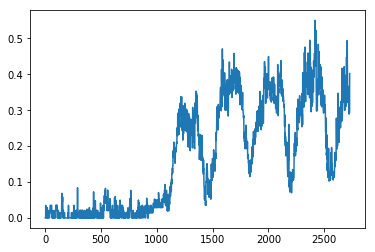

In [17]:
plt.plot(calendar_info[key]['Nuclear_indisponibility'].values/63200)

In [18]:
#visualisation des metriques
def display_metrics(model_eval, z_dim, factorDesc):
    if 'reconstruction_error' in model_eval.keys():
        for k,v in model_eval['reconstruction_error'].item():
            print(k, ' : ', v)
    print('Mutual Information Gap : %.2f'%model_eval['mig'])

    fig = plt.figure(dpi=100,figsize=(10,8))

    plt.subplot(1, 3, 1)
    fig.subplots_adjust(hspace=0.5)
    plt.bar(factorDesc.keys(),model_eval['informativeness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.ylim(top=1)
    for index,data in enumerate(model_eval['informativeness']):
        plt.text(x=index - 0.5, y =data+0.01 , s="%.2f"%data , fontdict=dict(fontsize=10))
    plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']))

    plt.subplot(1, 3, 2)
    plt.bar(np.arange(z_dim)+1,model_eval['disentanglement'])
    plt.xlabel('latent variables')
    plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

    plt.subplot(1, 3, 3)
    plt.bar(factorDesc.keys(),model_eval['compactness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.title('Compactness')
    plt.tight_layout();

In [19]:
#visualisation d'une représentation 2D dans le notebook
def prez_2D(x_encoded, factorMatrix):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation du lag par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,3], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');

In [20]:
#Visualisation des courbes de charge en entrée et reconstruite par le modèle

def display_loads(dict_x,date,scaler):
    
    fig = plt.figure(dpi=100,figsize=(5,5))
    for i,(name,x) in enumerate(dict_x.items()):
        x = scaler.inverse_transform(x)
        plt.plot(x, label = name)
        
    plt.xlabel('hours')
    plt.ylabel('load (MW)')
    plt.xlim((0,24))
    plt.legend(loc='lower right')
    plt.grid();

In [21]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,35,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,70,35,24,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = dataset['train']['x'][0].shape[1]

In [22]:
# paramètres du modèle variationnel choisi

## pour l'erreur de reconstruction (entre L1 et L2)
is_L2_Loss=False

## pour le choix du prior univarié exponentiel entre 'Gaussian' et 'Laplace':
prior = 'Laplace'

## pour la régularisation de la fonction objectif : VAE classique --> beta = 1 et gamma = 0
Beta = K.variable(0.5, dtype='float32') 

InfoVAE = True #pour activer la régularisation supplémentaire InfoVAE
Gamma = K.variable(8., dtype='float32')

Instructions for updating:
Colocations handled automatically by placer.


In [23]:
# paramètres de l'entrainement du modèle
epochs = 800
batch_size = 16

In [24]:
# création du modèle
name_model = 'vae'
log_dir_projector=path_main_folder+"/notebooks/logs/Interconnections/"+name_model+"/projector" #pour créer le dossier du projeteur tensorboard
log_dir_model=path_main_folder+"/notebooks/logs/Interconnections/"+name_model+"/model" #pour créer le dossier de sauvegarde du modèle
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model

model_vae = CVAE.cvae_model.CVAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=1, InfoVAE=InfoVAE,
                                beta=Beta, gamma = Gamma,  is_L2_Loss=is_L2_Loss,
                                name=name_model, output=path_out)

InfoVAE :  True
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 24)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 4302        x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 4)            0        

In [25]:
#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/Interconnections/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)

In [26]:
#apprentissage du modèle
 #use verbose=1 to see logs of training at every epoch
runTraining = False
if runTraining:
    model_vae.main_train(dataset, training_epochs=epochs, batch_size=batch_size, verbose=1,callbacks=[tensorboard],validation_split=0.2)

In [27]:
#charger le modèle déjà entrainé si besoin
load_model=1-runTraining
if load_model:
    model_vae.load_model(os.path.join(path_out, name_model, 'models'))

In [28]:
# Récupération de la représentation latente via les distributions a posteriori des profils
input_encoder = dataset['train']['x']
x_train_encoded, variance = model_vae.encoder.predict(input_encoder)
variance_train= np.exp(variance)

Mutual Information Gap : 0.02


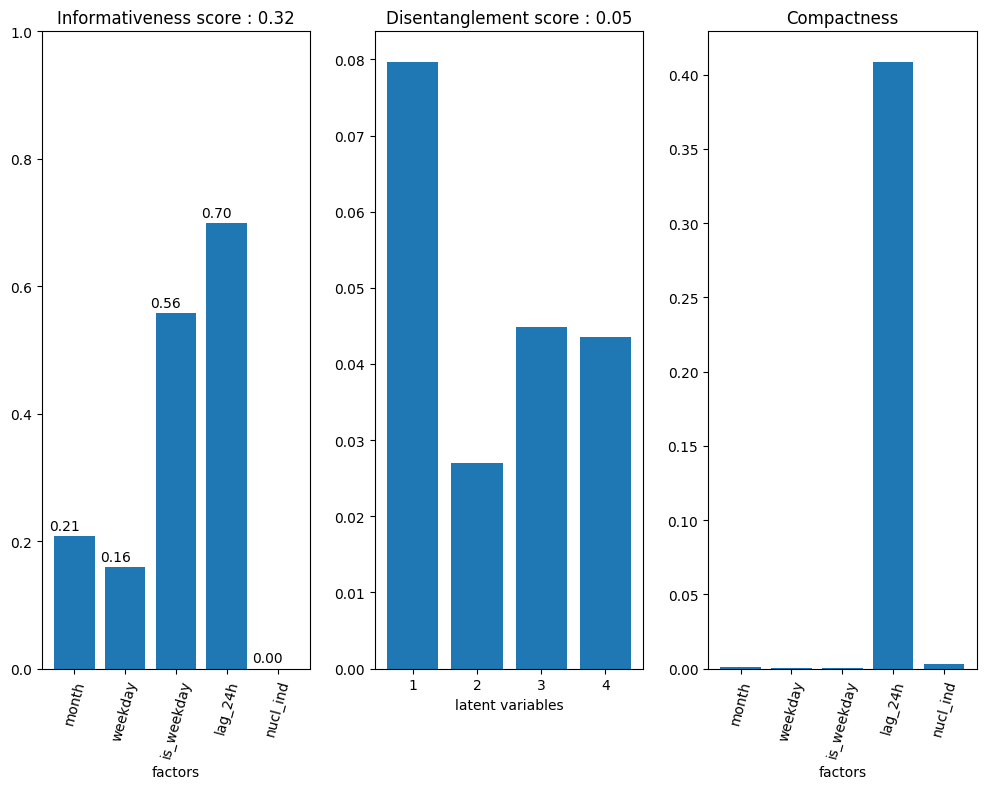

In [29]:
model_eval, importanceMatrix =evaluateLatentCode(x_train_encoded, factorMatrix['train'], factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)

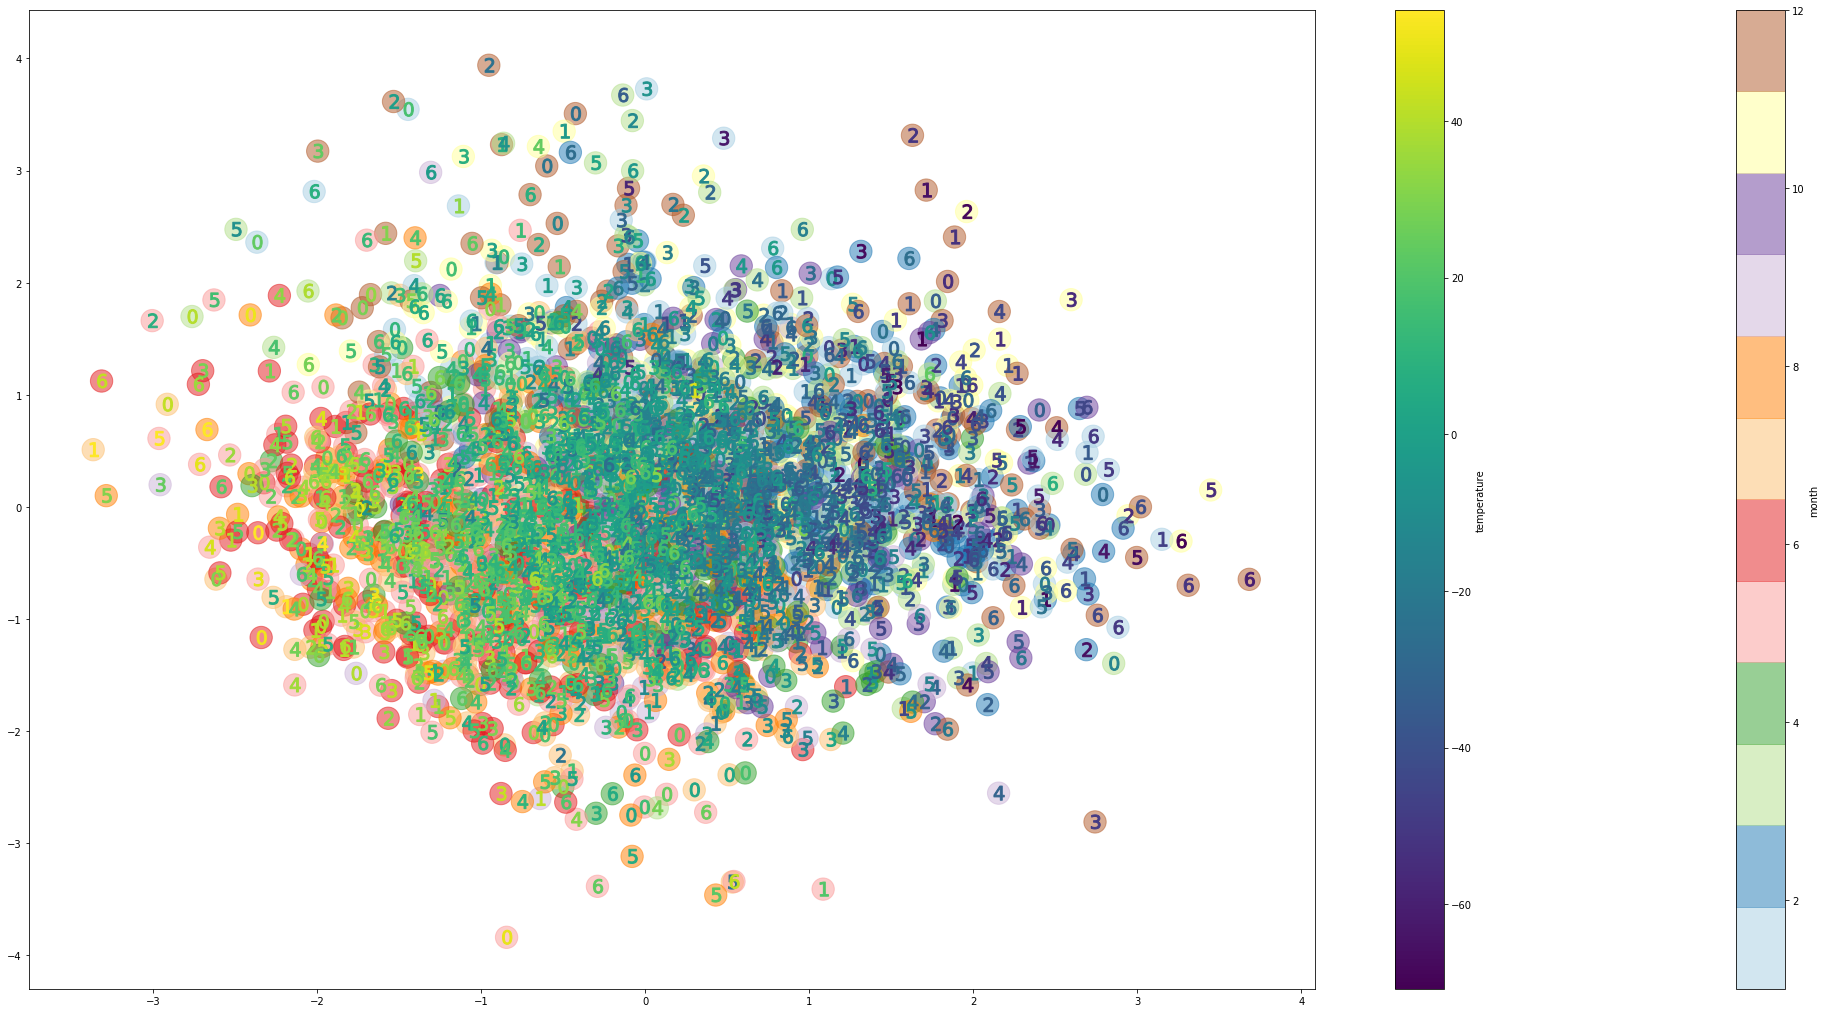

In [29]:
prez_2D(x_train_encoded, factorMatrix['train'])

In [30]:
stats.describe(x_train_encoded)

DescribeResult(nobs=2729, minmax=(array([-3.342656 , -4.087378 , -3.3401108, -3.1230326], dtype=float32), array([2.6257699, 4.193201 , 3.709719 , 4.5065966], dtype=float32)), mean=array([-0.03627213, -0.00705915, -0.02607913,  0.08157898], dtype=float32), variance=array([0.7305479, 0.9298558, 1.1778535, 0.9431241], dtype=float32), skewness=array([-0.23271154, -0.08963117,  0.08078072,  0.14101653], dtype=float32), kurtosis=array([ 0.43011022,  0.9586973 , -0.2458148 ,  0.40940022], dtype=float32))

## With the modal test

In [96]:
name_model = 'vae_mixture'
log_dir_projector=path_main_folder+"/notebooks/logs/Interconnections/"+name_model+"/projector" #pour créer le dossier du projeteur tensorboard
log_dir_model=path_main_folder+"/notebooks/logs/Interconnections/"+name_model+"/model" #pour créer le dossier de sauvegarde du modèle
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
Gamma = K.variable(8., dtype='float32')
Beta = K.variable(0.5, dtype='float32')
vae_mixture = CVAE.cvae_model_mixture.CVAE_mixture(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=3.e-6,
                                input_dim=input_dim, cond_dim=1,
                                beta=Beta, is_L2_Loss=False,
                                prior_mu= np.linspace(-5, 5, num=8, endpoint=True),         
                                name=name_model, output=path_out)

L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 24)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 38718       x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 4)            0           encoder[1][3]

In [97]:
#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/Interconnections/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)

In [98]:
#apprentissage du modèle
 #use verbose=1 to see logs of training at every epoch
runTraining = False
if runTraining:
    vae_mixture.main_train(dataset, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.2)

In [99]:
#charger le modèle déjà entrainé si besoin
load_model=1-runTraining
if load_model:
    vae_mixture.load_model(os.path.join(path_out, name_model, 'models'))

In [100]:
# Récupération de la représentation latente via les distributions a posteriori des profils
input_encoder = dataset['train']['x']
x_train_encoded, mix_mu_train, mix_sigma_train, y_train = vae_mixture.encoder.predict(input_encoder)
variance_train= np.sum(np.exp(mix_sigma_train)*(np.swapaxes(np.tile(y_train, (4,1,1)),0,1)**2), axis=2)

Mutual Information Gap : 0.03


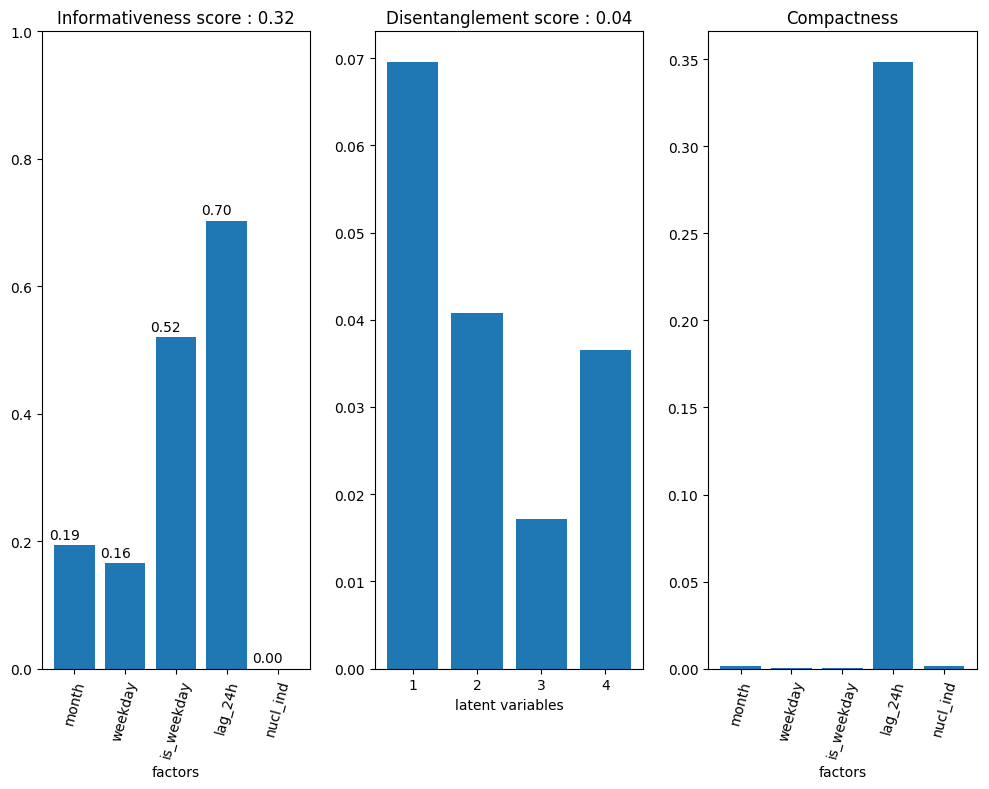

In [101]:
model_eval, importanceMatrix =evaluateLatentCode(x_train_encoded, factorMatrix['train'], factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)

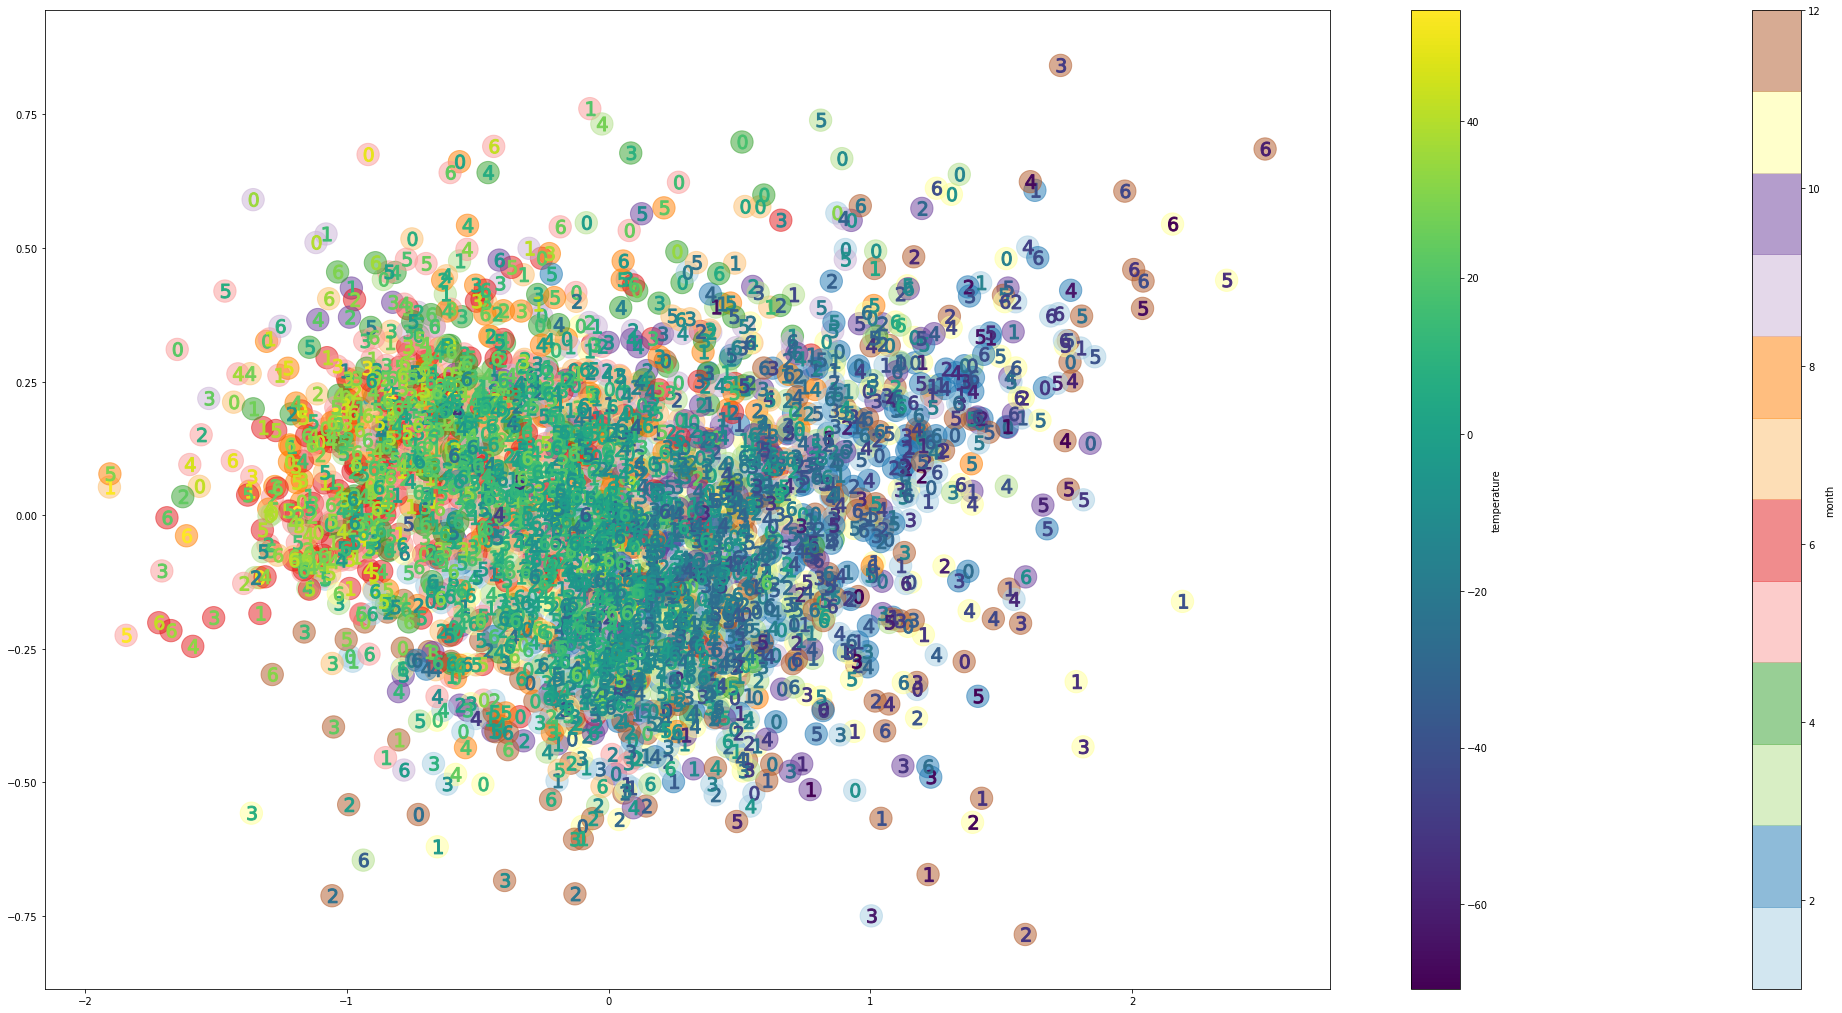

In [102]:
prez_2D(x_train_encoded, factorMatrix['train'])

## The study has confirmed the importance of the amount of exchanges at D-1. What can be found with ht evae conditionned on it ?

In [30]:
dict_xconso['train']['lag24h'] = dict_xconso['train'].consumption.shift(periods=24, fill_value=0)
dict_xconso['train']

,ds,consumption,lag24h
0,2012-01-01 00:30:00,1.127200,0.000000
1,2012-01-01 01:30:00,1.154255,0.000000
2,2012-01-01 02:30:00,0.442826,0.000000
3,2012-01-01 03:30:00,0.832264,0.000000
4,2012-01-01 04:30:00,0.758339,0.000000
5,2012-01-01 05:30:00,0.211145,0.000000
6,2012-01-01 06:30:00,-0.371106,0.000000
7,2012-01-01 07:30:00,-0.162288,0.000000
8,2012-01-01 08:30:00,-0.189724,0.000000
9,2012-01-01 09:30:00,0.423773,0.000000


In [31]:
type_cond = ['lag24h']
dataset_cond = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=type_cond)

lag24h (2729, 24)


In [32]:
name_model = 'cvae_mixture'
log_dir_projector=path_main_folder+"/notebooks/logs/Interconnections/"+name_model+"/projector" #pour créer le dossier du projeteur tensorboard
log_dir_model=path_main_folder+"/notebooks/logs/Interconnections/"+name_model+"/model" #pour créer le dossier de sauvegarde du modèle
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
Gamma = K.variable(8., dtype='float32')
Beta = K.variable(0.5, dtype='float32')
cvae_mixture = CVAE.cvae_model_mixture.CVAE_mixture(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=3.e-5,
                                input_dim=input_dim, cond_dim=dataset_cond['train']['x'][1].shape[1],
                                beta=Beta, is_L2_Loss=False,
                                prior_mu= np.linspace(-5, 5, num=8, endpoint=True),         
                                name=name_model, output=path_out)

L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 24)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 24)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 63351       x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 4)            0           encoder[1][3]

In [33]:
#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/Interconnections/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)

In [34]:
#apprentissage du modèle
 #use verbose=1 to see logs of training at every epoch
runTraining = False
if runTraining:
    cvae_mixture.main_train(dataset_cond, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.2)

In [35]:
#charger le modèle déjà entrainé si besoin
load_model=1-runTraining
if load_model:
    cvae_mixture.load_model(os.path.join(path_out, name_model, 'models'))

In [36]:
# Récupération de la représentation latente
input_encoder = dataset_cond['train']['x']
x_train_encoded, mix_mu_train, mix_sigma_train, y_train = cvae_mixture.encoder.predict(input_encoder)
variance_train= np.sum(np.exp(mix_sigma_train)*(np.swapaxes(np.tile(y_train, (4,1,1)),0,1)**2), axis=2)

Mutual Information Gap : 0.00


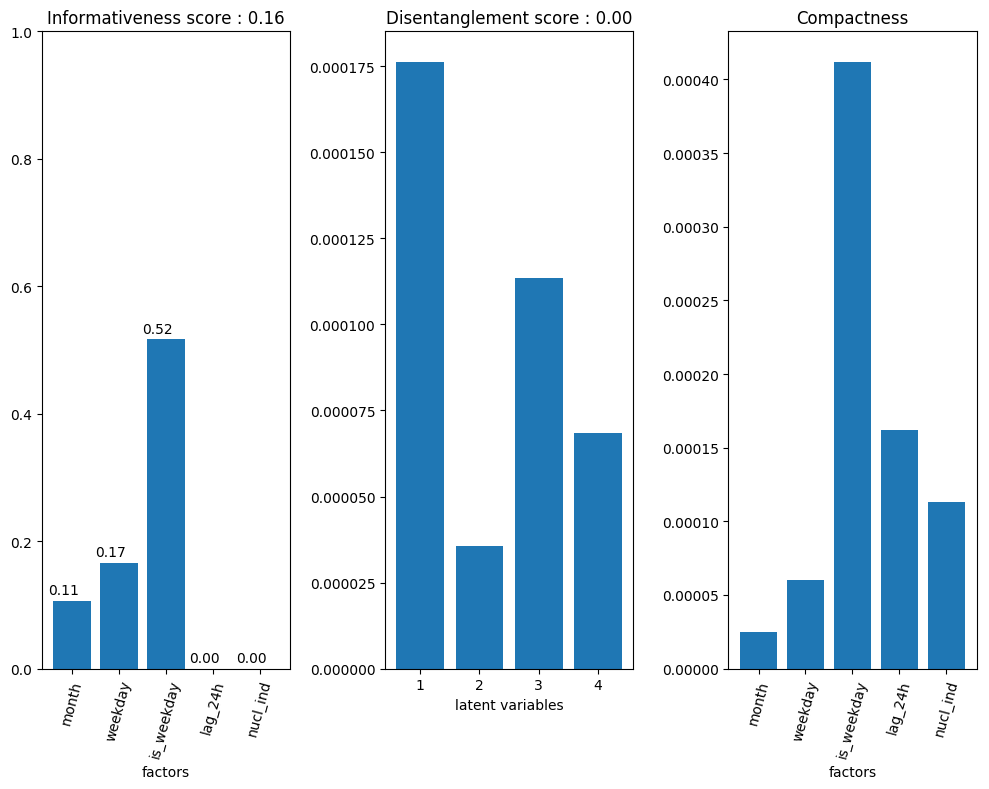

In [37]:
model_eval, importanceMatrix =evaluateLatentCode(x_train_encoded, factorMatrix['train'], factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)

In [54]:
for k in range(z_dim):
    rot = PCA(z_dim)
    rot_data = rot.fit_transform(x_train_encoded)[:,k]
    norm_data_mu = np.mean(rot_data)
    norm_data_sigma = np.std(rot_data)
    print(stats.kstest(rot_data, lambda x:stats.norm.cdf(x,loc=norm_data_mu, scale=norm_data_sigma)))

KstestResult(statistic=0.04792694807340281, pvalue=7.182686542382304e-06)
KstestResult(statistic=0.056061725723042355, pvalue=7.097811106001594e-08)
KstestResult(statistic=0.03158341266990505, pvalue=0.008640687260758312)
KstestResult(statistic=0.02946751330918912, pvalue=0.01748831528318671)


In [58]:
stats.pearsonr(x_train_encoded, stats.multivariate_normal.rvs(mean=np.zeros(z_dim),size=nPoints))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

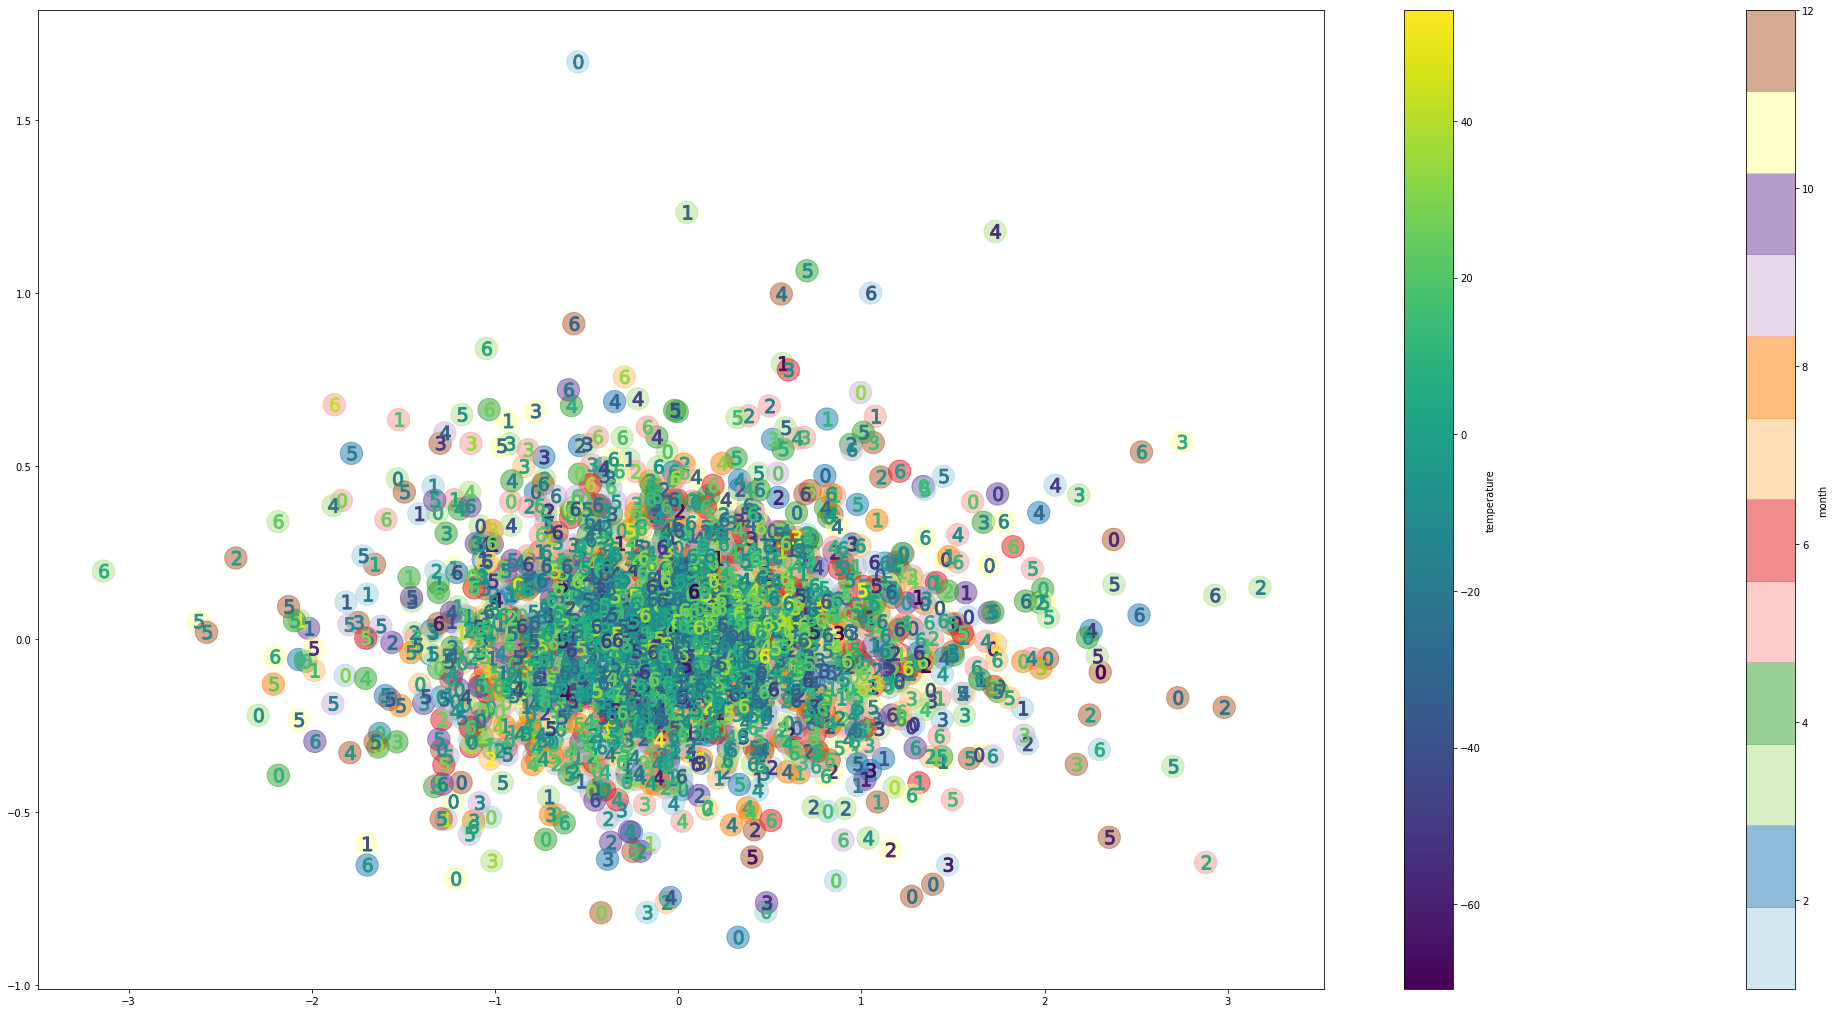

In [94]:
prez_2D(x_train_encoded, factorMatrix['train'])

In [59]:
#analysis of clusters

from sklearn.cluster import AgglomerativeClustering

clt = AgglomerativeClustering(n_clusters=13)
clt.fit(x_train_encoded)
spec_clt = clt.labels_
dash = '-' * 100
print(dash)
print('{:<6s}{:>10s}{:>20s}{:>40s}'.format('Group', 'Number', 'Is_weekend (%)', 'Month presence order'))
print(dash)

for i in np.unique(spec_clt):
    indix = np.where(spec_clt==i)
    n_i = calendar_info['train'].iloc[indix].shape[0]
    decomposition, counts = np.unique(calendar_info['train']['month'].loc[indix], return_counts=True)
    month_imp = str(decomposition[np.argsort(counts)[::-1]])
    wkd_perc = 1 - np.sum(calendar_info['train'].iloc[indix]['is_weekday'])/n_i
    print('{:<6.0f}{:>10.0f}{:>20.1f}{:>40s}'.format(i, n_i,wkd_perc*100, month_imp))
    

----------------------------------------------------------------------------------------------------
Group     Number      Is_weekend (%)                    Month presence order
----------------------------------------------------------------------------------------------------
0             79                41.8   [12  4  1 11  3  5  7  2 10  8  6  9]
1            371                32.3   [ 8  6  5  7  1 11  4 10  3 12  9  2]
2            439                23.2   [ 3  1  4  2 10 12 11  9  5  6  7  8]
3            159                39.0   [ 4  5  3  2  1 10 11  6 12  7  9  8]
4            459                28.8   [ 6 11 12  8  1  2  5  7  3 10  4  9]
5            285                18.6   [ 8  7  1 10  4  2  9  3  6  5 12 11]
6             42                47.6   [12  3  5  1 11 10  4  2  9  8  7  6]
7            117                38.5   [12  5 11  1 10  3  6  8  7  9  2  4]
8            375                25.3   [ 6  7  9  2  4  5 10  3  8 12 11  1]
9            110            

In [60]:
from pyod.models.cblof import CBLOF

clf = CBLOF(n_clusters=10,contamination=0.1,check_estimator=False, random_state=42)
clf_name='CBLOF'
print('fitting', clf_name)
# fit the data and tag outliers
clf.fit(x_train_encoded)
outliers = clf.predict(x_train_encoded)
stats.describe(np.sum(dataset_cond['train']['x'][0][outliers ==1], axis=1))

fitting CBLOF


DescribeResult(nobs=273, minmax=(-70.78674355111546, 54.52110590033103), mean=2.2871729393569327, variance=734.2446658453356, skewness=-0.2599296785996383, kurtosis=-0.8689284207138206)

In [61]:
stats.describe(np.sum(dataset_cond['train']['x'][1][outliers ==1], axis=1))

DescribeResult(nobs=273, minmax=(-74.87012299955379, 47.55733589097956), mean=-5.78741405139132, variance=554.6396097879605, skewness=-0.35513291517640877, kurtosis=-0.31956750222995645)

Plus petit score de silhouette pour 13 clusters


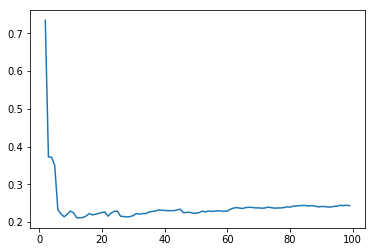

In [62]:
from sklearn.metrics import silhouette_score

silhouette_scr=[]
n_cl = np.arange(2,100,step=1,dtype=int)
for n in n_cl:
    clt=AgglomerativeClustering(n_clusters=n)
    clt.fit(x_train_encoded[outliers==1])
    sil_scr = silhouette_score(x_train_encoded[outliers==1], clt.labels_)
    silhouette_scr.append(sil_scr)
    
min_sil_scr = np.argmin(silhouette_scr)
print('Plus petit score de silhouette pour {} clusters'.format(n_cl[min_sil_scr]))
plt.plot(n_cl, silhouette_scr)

In [63]:
clt = AgglomerativeClustering(n_clusters=13)
clt.fit(x_train_encoded[outliers==1])
spec_clt = clt.labels_
dash = '-' * 100
print(dash)
print('{:<6s}{:>10s}{:>20s}{:>40s}'.format('Group', 'Number', 'Is_weekend (%)', 'Month presence order'))
print(dash)

for i in np.unique(spec_clt):
    indix = np.where(spec_clt==i)
    n_i = calendar_info['train'].iloc[indix].shape[0]
    decomposition, counts = np.unique(calendar_info['train']['month'].loc[indix], return_counts=True)
    month_imp = str(decomposition[np.argsort(counts)[::-1]])
    wkd_perc = 1 - np.sum(calendar_info['train'].iloc[indix]['is_weekday'])/n_i
    print('{:<6.0f}{:>10.0f}{:>20.1f}{:>40s}'.format(i, n_i,wkd_perc*100, month_imp))

----------------------------------------------------------------------------------------------------
Group     Number      Is_weekend (%)                    Month presence order
----------------------------------------------------------------------------------------------------
0             69                26.1                     [1 2 8 6 5 9 3 7 4]
1             16                18.8                           [8 6 9 7 3 2]
2             20                30.0                       [7 8 6 4 9 5 1 3]
3             10                60.0                           [3 7 1 9 5 4]
4             29                13.8                       [5 4 9 8 6 3 7 2]
5             16                31.2                           [3 9 4 8 7 6]
6             24                37.5                     [5 2 1 6 4 7 3 9 8]
7             10                20.0                             [8 7 3 9 2]
8              2                50.0                                   [9 6]
9             15            

In [65]:
calendar_info['train'].iloc[np.where(spec_clt==8)]

,ds,month,weekday,is_weekday,year,Nuclear_indisponibility
163,2012-06-12,6,1,1,2012,0.0
244,2012-09-01,9,5,0,2012,915.0


## On regarde l'importance des prix de marchés de l'électricité

In [20]:
import requests
from requests_xml import XMLSession
from time import sleep

In [111]:
market_id0 = [k for k in range(len(calendar_info['train'].ds)) if calendar_info['train'].ds.iloc[k].date()==datetime(2015,1,6).date()][0]

from tqdm import tqdm

elec_prices = pd.DataFrame(columns=['ds']+[str(h) for h in range(24)])
elec_prices=[elec_prices]*4

session = XMLSession()

for k in tqdm(np.arange(market_id0+elec_prices[0].shape[0], len(calendar_info['train'].ds), step=1), desc='date'):
    dt = calendar_info['train'].ds.iloc[k].strftime('%d/%m/%Y')
    dt_2 = calendar_info['train'].ds.iloc[k].strftime('%d/%m/%Y')

    url = 'https://www.rte-france.com/getEco2MixXml.php?type=donneesMarche'
    params = {"type":"donneesMarche","":"", "dateDeb":dt, "dateFin":dt_2, "mode":"NORM"}
    sleep(np.random.random())
    r = session.get(url, params=params)
    item = r.xml.xpath('//type')
    
    for n,p in enumerate([6,2,0,9]):
        vals = item[p].xpath('//valeur')
        if p==2 and vals[0].text == 'ND':
            vals = item[p+1].xpath('//valeur')
        if vals[0].text == 'ND':
            pp = [float('Nan')]*24
        else:
            pp = [float(v.text) for v in vals]    
        prices = pd.DataFrame(data=np.asarray([calendar_info['train'].ds.iloc[k]]+pp).reshape(1,-1), columns=['ds']+[str(h) for h in range(24)])
        elec_prices[n] = elec_prices[n].append(prices, ignore_index=True)

In [125]:
elec_p_FR = pd.read_csv(path_data+'/NTC/electricity_prices_FR.csv')
elec_p_DE = pd.read_csv(path_data+'/NTC/electricity_prices_DE.csv')
elec_p_BE = pd.read_csv(path_data+'/NTC/electricity_prices_BE.csv')
elec_p_NL = pd.read_csv(path_data+'/NTC/electricity_prices_NL.csv')

In [126]:
elec_p_FR

,ds,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,2015-01-06 00:30:00,45.56,40.28,39.20,36.22,34.04,38.58,43.32,50.00,49.53,...,41.45,40.08,43.62,48.55,52.32,53.10,48.78,43.91,44.58,45.73
1,2015-01-07 00:30:00,40.00,36.69,37.45,32.08,29.48,34.94,41.74,49.17,54.44,...,50.88,48.00,47.14,51.07,52.46,48.78,47.45,42.02,45.57,45.60
2,2015-01-08 00:30:00,43.88,35.65,35.87,30.17,24.54,32.00,40.96,49.53,48.07,...,43.47,38.27,41.07,47.97,51.25,50.31,47.97,40.50,43.80,44.05
3,2015-01-09 00:30:00,32.06,29.71,28.53,23.75,16.05,21.44,31.86,44.00,45.82,...,36.29,29.47,30.09,35.43,41.00,38.95,32.53,26.69,26.56,25.26
4,2015-01-10 00:30:00,19.04,15.96,13.70,11.01,9.08,9.28,11.76,15.84,16.93,...,16.21,11.34,14.15,18.64,24.45,27.75,24.56,18.75,25.81,27.67
5,2015-01-11 00:30:00,26.95,24.22,27.08,20.91,13.09,16.41,18.72,17.21,21.20,...,23.39,12.70,18.49,25.81,35.48,42.00,36.08,31.80,33.00,32.19
6,2015-01-12 00:30:00,27.59,26.81,25.75,17.86,15.16,19.84,33.98,45.51,48.06,...,36.31,32.37,33.53,41.31,47.89,48.42,41.89,35.24,37.44,35.00
7,2015-01-13 00:30:00,33.04,26.56,26.29,17.44,11.26,22.29,33.78,44.94,49.04,...,36.48,33.05,34.13,43.03,49.22,46.38,42.44,33.36,33.97,31.39
8,2015-01-14 00:30:00,34.58,29.67,27.49,21.30,15.59,18.90,34.78,48.00,47.79,...,42.04,38.94,41.15,48.93,50.99,50.94,44.99,38.62,39.54,38.92
9,2015-01-15 00:30:00,30.44,24.91,22.67,16.87,15.43,16.05,32.33,48.62,49.01,...,38.18,35.54,35.68,41.66,50.45,49.47,42.98,35.42,35.49,34.75


In [127]:
id_na=[k for k in range(elec_p_FR.shape[0]) if elec_p_FR['0'].isna()[k] or elec_p_BE['0'].isna()[k] or elec_p_DE['0'].isna()[k]]
id_na = list(np.unique(id_na))
id_na

[325,
 326,
 327,
 328,
 329,
 383,
 486,
 487,
 492,
 610,
 639,
 1039,
 1040,
 1041,
 1042,
 1294,
 1428,
 1590]

In [128]:
elec_p_FR=elec_p_FR.drop(axis=0, labels=id_na).reset_index()
elec_p_DE=elec_p_DE.drop(axis=0, labels=id_na).reset_index()
elec_p_BE=elec_p_BE.drop(axis=0, labels=id_na).reset_index()

In [129]:
elec_p_FR.ds[elec_p_FR['0'].isna()]

Series([], Name: ds, dtype: object)

In [130]:
id_market = [k for k in range(calendar_info['train'].ds.shape[0]) if calendar_info['train'].ds.values[k] in elec_p_FR.ds.astype('datetime64').values]
len(id_market)

0

In [131]:
Delta_FR_DE = np.mean(elec_p_FR.iloc[:,2:].values - elec_p_DE.iloc[:,2:].values, axis=1)
Delta_FR_BE = np.mean(elec_p_FR.iloc[:,2:].values - elec_p_BE.iloc[:,2:].values, axis=1)

In [132]:
stats.describe(Delta_FR_BE)

DescribeResult(nobs=1619, minmax=(-152.0570833333333, 137.24124999999995), mean=-2.4582500772081533, variance=84.53750638783839, skewness=-4.11605487654903, kurtosis=117.4042819337567)

In [137]:
calendar_info['train'].ds.dt.date.values[5] in elec_p_FR.ds.astype('datetime64').dt.date.values

False

In [133]:
factorDesc.update({'D_FR_DE':'regressor', 'D_FR_BE':'regressor'})
factorDesc

{'month': 'category',
 'weekday': 'category',
 'is_weekday': 'category',
 'lag_24h': 'regressor',
 'nucl_ind': 'regressor',
 'D_FR_DE': 'regressor',
 'D_FR_BE': 'regressor'}

In [134]:
factorMatrix2=np.c_[factorMatrix['train'][id_market,:], Delta_FR_DE, Delta_FR_DE]

ValueError: all the input array dimensions except for the concatenation axis must match exactly

Mutual Information Gap : 0.00


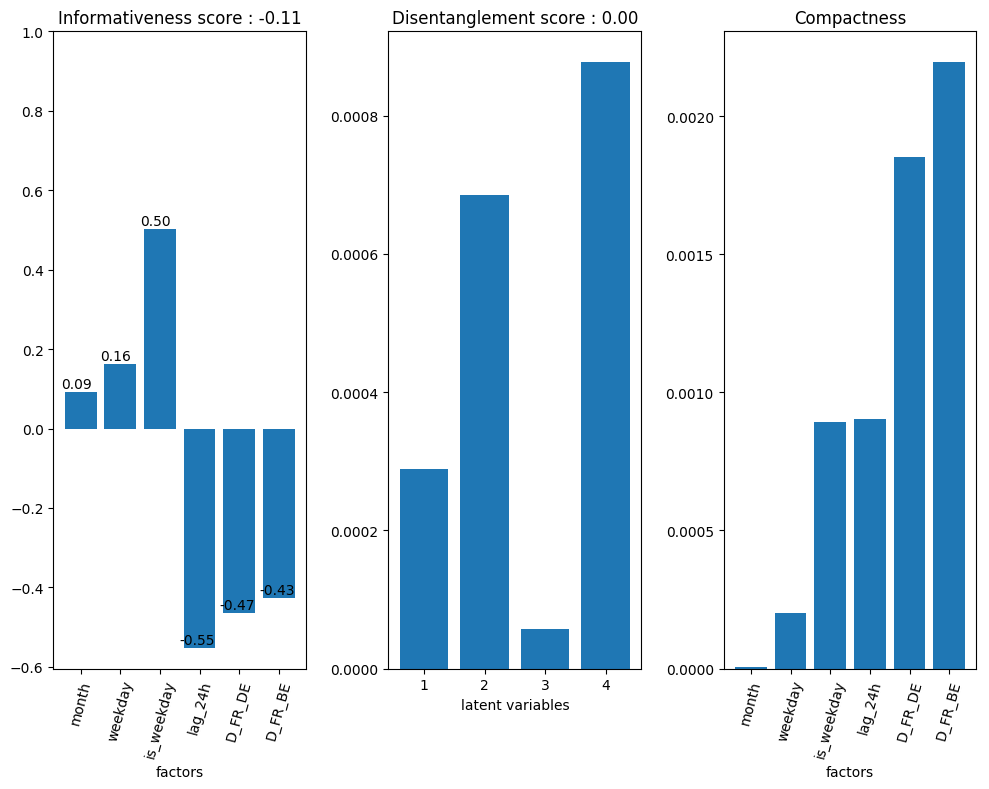

In [164]:
model_eval, importanceMatrix =evaluateLatentCode(x_train_encoded[id_market,:], factorMatrix2, factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)

In [103]:
from pyod.models.cblof import CBLOF

clf = CBLOF(n_clusters=8,contamination=0.05,check_estimator=False, random_state=42)
clf.fit(x_train_encoded)
outliers = clf.predict(x_train_encoded)

In [104]:
for i,year in enumerate(np.unique(calendar_info['train'].year.values)):
    print(calendar_info['train'][['ds', 'year']].iloc[outliers==1].pivot(columns = 'year').iloc[:,i].dropna())

357   2012-12-23
361   2012-12-27
Name: (ds, 2012), dtype: datetime64[ns]
489   2013-05-04
490   2013-05-05
493   2013-05-08
495   2013-05-10
496   2013-05-11
503   2013-05-18
511   2013-05-26
517   2013-06-01
523   2013-06-07
524   2013-06-08
584   2013-08-07
585   2013-08-08
586   2013-08-09
587   2013-08-10
589   2013-08-12
Name: (ds, 2013), dtype: datetime64[ns]
907   2014-07-05
911   2014-07-09
912   2014-07-10
913   2014-07-11
915   2014-07-13
916   2014-07-14
928   2014-07-26
929   2014-07-27
930   2014-07-28
931   2014-07-29
934   2014-08-01
937   2014-08-04
938   2014-08-05
939   2014-08-06
941   2014-08-08
944   2014-08-11
945   2014-08-12
946   2014-08-13
947   2014-08-14
948   2014-08-15
Name: (ds, 2014), dtype: datetime64[ns]
1230   2015-05-24
1231   2015-05-25
1257   2015-06-20
1258   2015-06-21
1279   2015-07-12
1280   2015-07-13
1281   2015-07-14
1293   2015-07-26
1294   2015-07-27
1296   2015-07-29
1298   2015-07-31
1299   2015-08-01
1300   2015-08-02
1305   2015-08-07

In [90]:
calendar_info['train'][['ds', 'year']].iloc[outliers==1].pivot(columns = 'year')

ds                                                              \
year       2012       2013       2014       2015       2016 2017       2018   
96   2012-04-06        NaT        NaT        NaT        NaT  NaT        NaT   
102  2012-04-12        NaT        NaT        NaT        NaT  NaT        NaT   
106  2012-04-16        NaT        NaT        NaT        NaT  NaT        NaT   
107  2012-04-17        NaT        NaT        NaT        NaT  NaT        NaT   
204  2012-07-23        NaT        NaT        NaT        NaT  NaT        NaT   
328  2012-11-24        NaT        NaT        NaT        NaT  NaT        NaT   
403         NaT 2013-02-07        NaT        NaT        NaT  NaT        NaT   
643         NaT 2013-10-14        NaT        NaT        NaT  NaT        NaT   
762         NaT        NaT 2014-02-10        NaT        NaT  NaT        NaT   
838         NaT        NaT 2014-04-27        NaT        NaT  NaT        NaT   
1017        NaT        NaT 2014-10-23        NaT        NaT  NaT        NaT   
1119        NaT        NaT        NaT 2015-02-02        NaT  NaT        NaT   
1195        NaT        NaT        NaT 2015-04-19        NaT  NaT        NaT   
1207        NaT        NaT        NaT 2015-05-01        NaT  NaT        NaT   
1288        NaT        NaT        NaT 2015-07-21        NaT  NaT        NaT   
1313        NaT        NaT        NaT 2015-08-15        NaT  NaT        NaT   
1341        NaT        NaT        NaT 2015-09-12        NaT  NaT        NaT   
1412        NaT        NaT        NaT 2015-11-22        NaT  NaT        NaT   
1418        NaT        NaT        NaT 2015-11-28        NaT  NaT        NaT   
1423        NaT        NaT        NaT 2015-12-03        NaT  NaT        NaT   
1427        NaT        NaT        NaT 2015-12-07        NaT  NaT        NaT   
1432        NaT        NaT        NaT 2015-12-12        NaT  NaT        NaT   
1446        NaT        NaT        NaT 2015-12-26        NaT  NaT        NaT   
1449        NaT        NaT        NaT 2015-12-29        NaT  NaT        NaT   
1452        NaT        NaT        NaT        NaT 2016-01-01  NaT        NaT   
1464        NaT        NaT        NaT        NaT 2016-01-13  NaT        NaT   
1494        NaT        NaT        NaT        NaT 2016-02-12  NaT        NaT   
1536        NaT        NaT        NaT        NaT 2016-03-25  NaT        NaT   
1537        NaT        NaT        NaT        NaT 2016-03-26  NaT        NaT   
1538        NaT        NaT        NaT        NaT 2016-03-27  NaT        NaT   
...         ...        ...        ...        ...        ...  ...        ...   
2528        NaT        NaT        NaT        NaT        NaT  NaT 2018-12-12   
2531        NaT        NaT        NaT        NaT        NaT  NaT 2018-12-15   
2533        NaT        NaT        NaT        NaT        NaT  NaT 2018-12-17   
2539        NaT        NaT        NaT        NaT        NaT  NaT 2018-12-23   
2542        NaT        NaT        NaT        NaT        NaT  NaT 2018-12-26   
2545        NaT        NaT        NaT        NaT        NaT  NaT 2018-12-29   
2548        NaT        NaT        NaT        NaT        NaT  NaT        NaT   
2562        NaT        NaT        NaT        NaT        NaT  NaT        NaT   
2576        NaT        NaT        NaT        NaT        NaT  NaT        NaT   
2581        NaT        NaT        NaT        NaT        NaT  NaT        NaT   
2588        NaT        NaT        NaT        NaT        NaT  NaT        NaT   
2589        NaT        NaT        NaT        NaT        NaT  NaT        NaT   
2594        NaT        NaT        NaT        NaT        NaT  NaT        NaT   
2597        NaT        NaT        NaT        NaT        NaT  NaT        NaT   
2600        NaT        NaT        NaT        NaT        NaT  NaT        NaT   
2609        NaT        NaT        NaT        NaT        NaT  NaT        NaT   
2616        NaT        NaT        NaT        NaT        NaT  NaT        NaT   
2619        NaT        NaT        NaT        NaT        NaT  Na

# Conclusion

Dans le code latent obtenu, on retrouve effectivement une distribution des profils journaliers qui semble corrélé avec le lag 24h donc ça confirme le fait de l'avoir utilisé comme input des modèles que tu avais fait.
On retrouve un fort conditionnement selon le fait que le jour en question soit un jour de weekend ou non, quasiment aussi importante que le lag 24h. A voir si l'inclure peut améliorer les prédictions ?

J'ai testé d'autres conditions à retrouver comme le prix de l'électricité dans les marchés extérieurs ou encore la disponibilité des tranches nucléaires. Et je n'ai pas eu du tout de corrélations.

J'ai aussi regardé les points atypiques, et des séries de jours ont été mis en évidence. Entre autres:

    2013 : du 4 au 11 mai ou du 7 au 12 août;
    2014 : du 9 au 14 juillet, du 26 juillet au 15 août;
    2015 : 24-25 mai, 20-21 juin, du 26 juillet au 20 août;
    2016 : du 11 au 14 juin;
    2017 : du 25 novembre au 3 décembre (vague de froid imprévue vraisemblablement);
    2018 : du 10 au 14 mars, du 8 mai au 28 juin (période avec beaucoup d'orages --> indisponibilité de lignes ?)

Pour les périodes d'août, je suppose que c'est lié à la baisse de demande sur cette période estivale. Pour dates en inter-saison, peut être y a t-il des évènements autres que météo qui ont impacté les contraintes aux interconnections. 


from tqdm import tqdm

new_tb= pd.DataFrame(pd.to_datetime(range(8*366), unit='D', origin=pd.Timestamp('2012-01-01')), columns=['ds'])
new_tb['Nuclear_indisponibility']=np.zeros(8*366)
old_list_ID=[]
for year in tqdm(reversed(list(np.arange(2012,2020,step=1)))):

    tb = pd.read_csv(path_data+'/DonneesIndisponibilitesProduction_'+str(year)+'.csv', encoding='iso8859_14')[['Filière','Début indispo', 'Fin Indispo', 'Puissance nominale', 'Puissance disponible restante', 'ID Indisponibilité de production']]
    tb = tb.iloc[np.where(tb['Filière']=='Nucléaire')].dropna()
    tb=tb.drop_duplicates(subset='ID Indisponibilité de production',keep='last', inplace=False).reset_index()
    tb['Début indispo'] = pd.to_datetime(tb['Début indispo'].values,format='%d/%m/%Y %H:%M')
    tb['Fin Indispo'] = pd.to_datetime(tb['Fin Indispo'].values,format='%d/%m/%Y %H:%M')

    tb['Delta_indispo'] = tb['Puissance nominale'] - tb['Puissance disponible restante']
    tb['Duration'] = (tb['Fin Indispo'] - tb['Début indispo']).dt.days + np.round((tb['Fin Indispo'] - tb['Début indispo']).dt.seconds/(24*3600))
    
    list_ID = list(tb['ID Indisponibilité de production'])
    
    for i in tqdm(range(tb.Duration.shape[0])):
        if tb['ID Indisponibilité de production'].values[i] not in old_list_ID:
            date_tg = np.where(new_tb.ds == tb['Début indispo'].dt.date.iloc[i])[0] + np.arange(0,np.int(tb.Duration.iloc[i]))
            date_tg = [date_id for date_id in date_tg if date_id < 8*366]
            new_tb['Nuclear_indisponibility'].iloc[date_tg] += tb['Delta_indispo'].values[i]
        
    old_list_ID  += list_ID